In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from torchvision import transforms

import pickle

from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT'
train_images = path + '/Train/RGB'
train_images_TIR = path + '/Train/TIR'
anno = path + '/Train/GT_'
dmap_folder = path + '/Train/DMAP'

In [3]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(12, 12))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        print(mask.sum())
    else:
        f, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        #print(mask.sum())
        
        
def plot_data(img,points,fig_size=(18,12)):
    p_img = img.copy()
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    for point in points:
        cv2.circle(p_img, tuple(point), radius=0,color=(0, 1, 0), thickness=5)
    ax.imshow(p_img)

In [4]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ],
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.9),
            A.Blur(blur_limit=3,p=0.2),
        ],
        additional_targets={'image': 'image'}
    )

In [11]:
class Video_Counting_Dataset(Dataset):
    def __init__(self,path,images_folder,dmap_folder,
                 seq_len=16,gt_folder=None,suffix='jpg',
                 tfms=None,mosaic=False,sample=0):
        super().__init__()
        
        self.path = path
        self.images_path = path + images_folder
        self.image_fnames = glob(self.images_path+f'/*.{suffix}')
        
        # TODO:
        # Be able to get sequences
        
        self.image_fnames = sorted(self.image_fnames,key=lambda x: int(x.split('/')[-1].split('.')[0]))
        self.dmap_folder = path + dmap_folder
        self.seq_len = seq_len
        self.transforms = tfms
        self.mosaic = mosaic
        self.gt_folder = path + gt_folder # test purpose
        self.sample = sample # 0 is consective, 1 is TSN
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        self.item_tfms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,std=self.std),
        ])
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self, idx):
        '''
            Get a sequence of frames
            Return: 
                frames, shape: seq, h,w,c
                dmaps, shape: seq, h,w
                gt_points, seq_len of each frame
        '''
        if self.sample:
            pass # TSN
        
        else:
            frames,dmaps,fns,gt_points = self._consective_sampling(idx)
            
        if not isinstance(self.transforms,type(None)):
            t,ch,h,w = frames.shape
            frames = frames.view(t*ch,h,w).permute(1,2,0).numpy()
            #frames = np.moveaxis(torch.permute(frames,-1,1).reshape(t*ch,h,w),0,-1)
            #dmaps = np.moveaxis(np.moveaxis(dmaps,-1,1).reshape(t*ch,h,w),0,-1)
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': frames,
                    'mask': dmaps
                })
            # TODO reshape
                frames, dmaps = aug['image'], aug['mask']
            frames = torch.from_numpy(frames).permute(2,0,1).view(t,ch,h,w)
            #frames = np.moveaxis(np.moveaxis(frames,-1,0).reshape(t,ch,h,w),1,-1)
        return frames, dmaps, fns, gt_points
    
    def _consective_sampling(self,idx):
        
        frames, d_maps, fns, gt_points = [],[],[],[]
        frame_diff = self.__len__() - idx
        if frame_diff >= self.seq_len:
            start_frame = idx
        elif frame_dff < self.seq_len:
            # random back off when sampling dont have enough samples
            idx -= frame_diff
            start_frame = round((idx - frame_diff) * np.random.rand())
        else:
            raise ValueError('start_frame init error...')
        for n in range(idx,idx+self.seq_len):
                fn = self.image_fnames[n]
                image,dmap,points = self._load_one_frame(fn)
                frames.append(image)
                d_maps.append(dmap)
                fns.append(fn)
                gt_points.append(points)
        
        return torch.stack(frames),np.array(d_maps),fns,np.array(gt_points)
    
    def _load_one_frame(self,fn):
        y_fn, p_fn = self._prepare_fn(fn)
        image = cv2.imread(fn)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        image = self.item_tfms(image)
        d_map, points = self._get_gts(y_fn,p_fn)
        return image, d_map, points
    
    def _prepare_fn(self,fn):
        file_name = fn.split('/')[-1].split('.')[0]
        y_fn = self.dmap_folder + '/' + file_name + 'Dmap.pkl'
        p_fn = self.gt_folder + '/' + file_name + 'R.xml'
        return y_fn, p_fn
    
    def _get_gts(self,y_fn,p_fn):
        d_map = np.load(y_fn,allow_pickle=True)
        if not self.gt_folder:
            return (None,0)
        with open(p_fn,'r') as f:
                data = f.read()
        test_data = bf.data(fromstring(data))
        points = self._get_annotation(test_data)
        return d_map, points
        
    def _get_annotation(self,xml_datas):
        points = []
        for data in xml_datas['annotation']['object']:
            if data['name']['$'] == 'person' or data['name']['$'] == 'person]':
                if 'point' in data:
                    x = data['point']['x']['$']
                    y = data['point']['y']['$']
                else:
                    x = data['bndbox']['xmin']['$']
                    y = data['bndbox']['ymin']['$']
                points.append((x,y))
            else: print(data['name']['$'] +' not a person...')
        return points
    
    def _normalize(self,img):
        img -= self.mean[None,None,...]
        img /= self.std[None,None,...]
        return img

In [12]:
train_dataset = Video_Counting_Dataset(path=path,
                                       images_folder='/Train/RGB',dmap_folder='/Train/DMAP',
                                       gt_folder='/Train/GT_',
                                       #tfms=[get_train_transforms()]#,get_train_image_only_transforms()]
)

In [13]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
def denoramlize(img):
    return img * std[...,None,None] + mean[...,None,None]

In [14]:
def collate_fn(batch):
    frames, dmaps, fns, gt_points = zip(*batch)
    return frames, dmaps, fns, gt_points

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=0,
        collate_fn=collate_fn,
    )

In [25]:
frames, dmaps, fns, gt_points = next(iter(train_loader))

In [32]:
test_frames = frames[0]
dsum = [i.sum() for i in dmaps[0]]
gt_sum = [len(i) for i in gt_points[0]]
dsum,gt_sum

([49.37149,
  51.881912,
  51.80949,
  53.29472,
  52.95735,
  49.64186,
  49.081577,
  48.257023,
  41.56717,
  39.868633,
  38.47172,
  57.412956,
  61.341545,
  61.749462,
  66.60895,
  66.66062],
 [52, 56, 54, 56, 56, 53, 51, 51, 44, 42, 40, 60, 64, 64, 69, 69])

In [28]:
gt_sum

[52, 56, 54, 56, 56, 53, 51, 51, 44, 42, 40, 60, 64, 64, 69, 69]

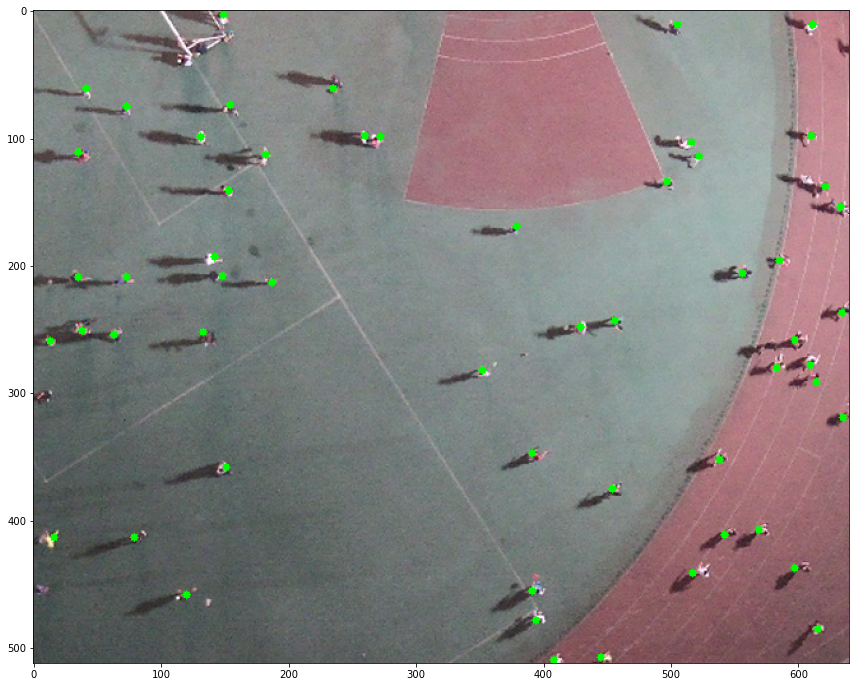

In [35]:
plot_data(denoramlize(test_frames[1]).permute(1,2,0).numpy(),gt_points[0][1])

In [20]:
test_frames = frames[0]
test_frames.shape

torch.Size([16, 3, 512, 640])

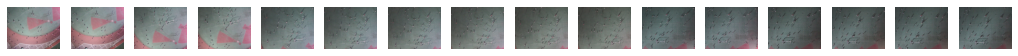

In [23]:
ig, axes = plt.subplots(ncols=16, nrows=1, figsize=(18,12))
for j, x in enumerate(test_frames):
    axes[j].imshow(denoramlize(x).permute(1,2,0).numpy())
    axes[j].axis('off')

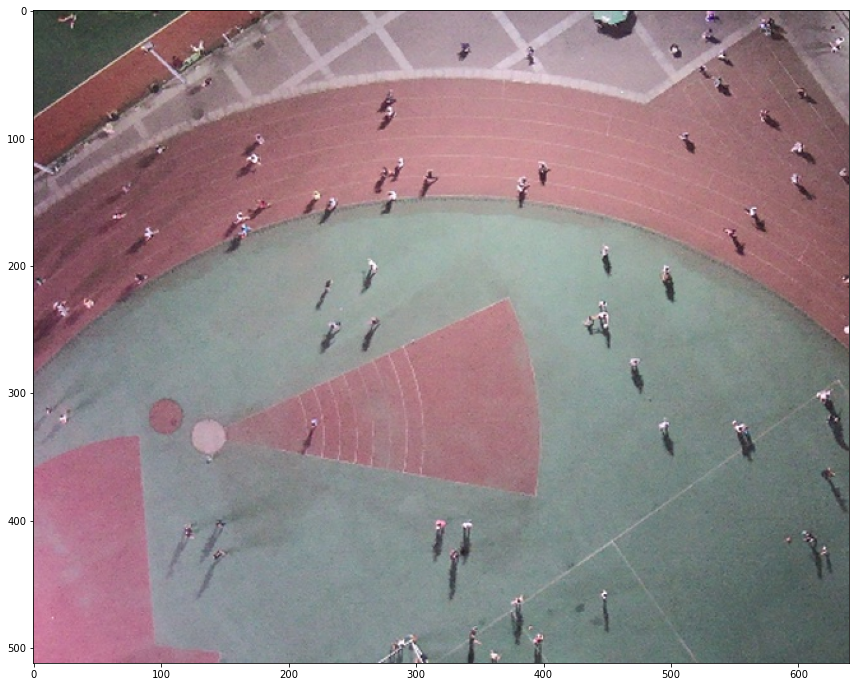

In [24]:
image = cv2.imread(fns[0][0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(image)

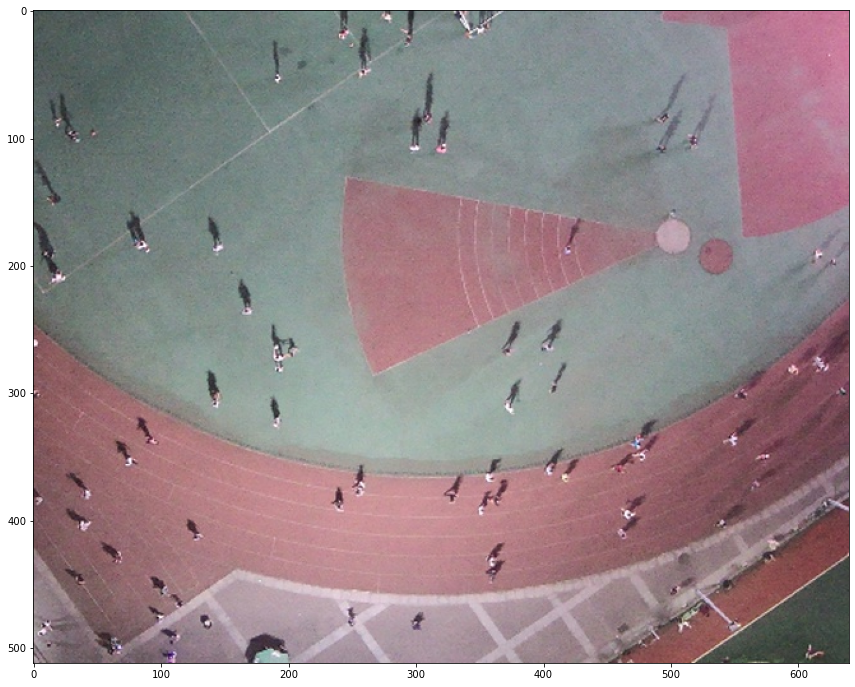

In [25]:
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(denoramlize(test_frames[0]).permute(1,2,0).numpy())

In [47]:
test_frames[0].shape

torch.Size([512, 640, 3])

In [74]:
len(frames[0])

16

In [108]:
transform = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=1.0),
#     A.OneOf([
#                 A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
#                                      val_shift_limit=0.2, p=0.9),
#                 A.RandomBrightnessContrast(brightness_limit=0.2, 
#                                            contrast_limit=0.2, p=0.9),
#             ],p=0.9),
    A.Blur(blur_limit=3,p=0.2),
            #A.Normalize(p=1.0,max_pixel_value=1.0),
])

In [35]:
test_frames = np.array(frames[0])
t,h,w,ch = test_frames.shape
test_frames.shape

(16, 512, 640, 3)

In [36]:
np.array(dmaps[0]).shape

(16, 512, 640)

In [141]:
test_image = np.moveaxis(np.moveaxis(test_frames,-1,1).reshape(t*ch,h,w),0,-1)

In [142]:
data = transform(image=test_image)['image']

In [143]:
data = np.moveaxis(np.moveaxis(data,-1,0).reshape(t,ch,h,w),1,-1)

In [144]:
data.shape

(16, 512, 640, 3)

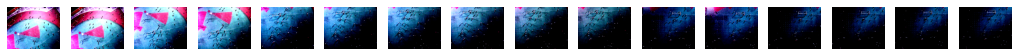

In [37]:
ig, axes = plt.subplots(ncols=16, nrows=1, figsize=(18,12))
for j, x in enumerate(test_frames):
    axes[j].imshow(x)
    #axes[i,j].set_title(ys.item())
    axes[j].axis('off')

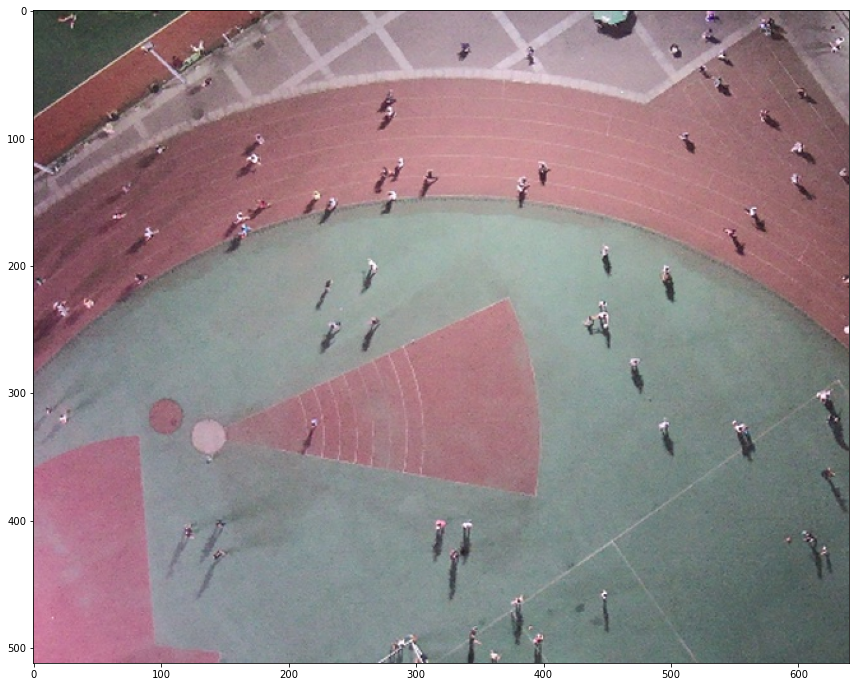

In [38]:
image = cv2.imread(fns[0][0])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
image = image/255.
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(image)

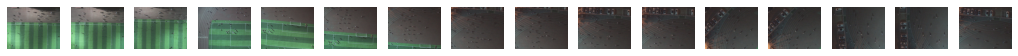

In [147]:
ig, axes = plt.subplots(ncols=16, nrows=1, figsize=(18,12))
for j, x in enumerate(data):
    axes[j].imshow(x)
    #axes[i,j].set_title(ys.item())
    axes[j].axis('off')

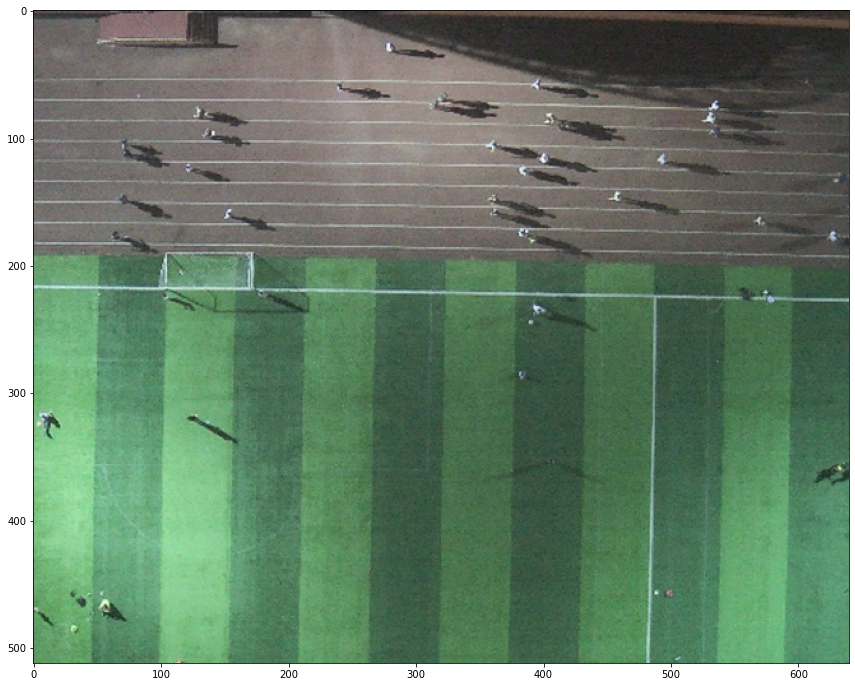

In [148]:
_,ax = plt.subplots(1,1,figsize=(16,12))
ax.imshow(data[0])

In [89]:
%%time
l = []
for i in range(1000):
    l.append(np.random.rand())
l = np.array(l)

CPU times: user 601 µs, sys: 3 µs, total: 604 µs
Wall time: 608 µs


In [91]:
%%time
l = np.array([])
for i in range(1000):
    np.append(l,np.random.rand())


CPU times: user 8.12 ms, sys: 3.82 ms, total: 11.9 ms
Wall time: 8.45 ms
